In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from glob import glob
import sys
from tqdm import tqdm
import matplotlib.pyplot as plt
from FCCA.fcca import FCCA, SparseFCCA

In [3]:
sys.path.append('/home/akumar/nse/neural_control')

In [4]:
from loaders import load_sabes
from utils import calc_loadings

In [5]:
fls = glob('/mnt/Secondary/data/sabes/*.mat')

In [6]:
dat = load_sabes(fls[2])
X = dat['spike_rates'].squeeze()

In [ ]:
# First test: Do FCCA and SparseFCCA give the same results with no sparsity regularization?

In [7]:
fcca = FCCA(T=3, d=2)
sfcca = SparseFCCA(T=3, d=2, alpha=0, opt_method='direct')

In [8]:
fcca.fit(X)

In [9]:
sfcca.fit(X)

In [10]:
fcca.score()

tensor(172.1741, dtype=torch.float64)

In [11]:
sfcca.score()

tensor(172.1936, dtype=torch.float64)

In [21]:
d = np.array([2, 4, 6, 10, 15])
alpha = np.linspace(0, 5, 10)

coefs = np.zeros((len(d),), dtype=object)
scores = np.zeros((len(d),))

scoefs = np.zeros((len(d), len(alpha)), dtype=object)
sscores = np.zeros((len(d), len(alpha)))

for i, d_ in tqdm(enumerate(d)):
    fcca = FCCA(T=1, d=d_, n_init=1, rng_or_seed=0)
    fcca.fit(X)
    score = fcca.score()
    scores[i] = score
    coefs[i] = fcca.coef_

    for j, a in enumerate(alpha):
        sfcca = SparseFCCA(T=1, d=d_, alpha=a, opt_method='direct', n_init=1, rng_or_seed=0)
        sfcca.fit(X)
        sscores[i, j] = sfcca.score()
        scoefs[i, j] = sfcca.coef_

0it [00:00, ?it/s]

4it [03:13, 48.39s/it]


In [23]:
sscores

array([[173.3709181 ],
       [173.14085392],
       [172.9971641 ],
       [172.73296581]])

In [22]:
scores

array([172.51769322, 171.70316815, 171.19217321, 170.55246141])

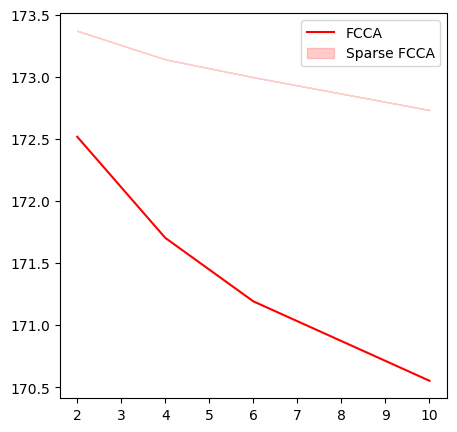

In [24]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(d, scores, label='FCCA', color='r')
#ax.plot(d, sscores[:, 0], label='Unregularized SFCCA')
ax.fill_between(d, sscores[:, 0], sscores[:, -1], alpha=0.2, label='Sparse FCCA', color='r')
ax.legend()

In [ ]:
alpha_idxs

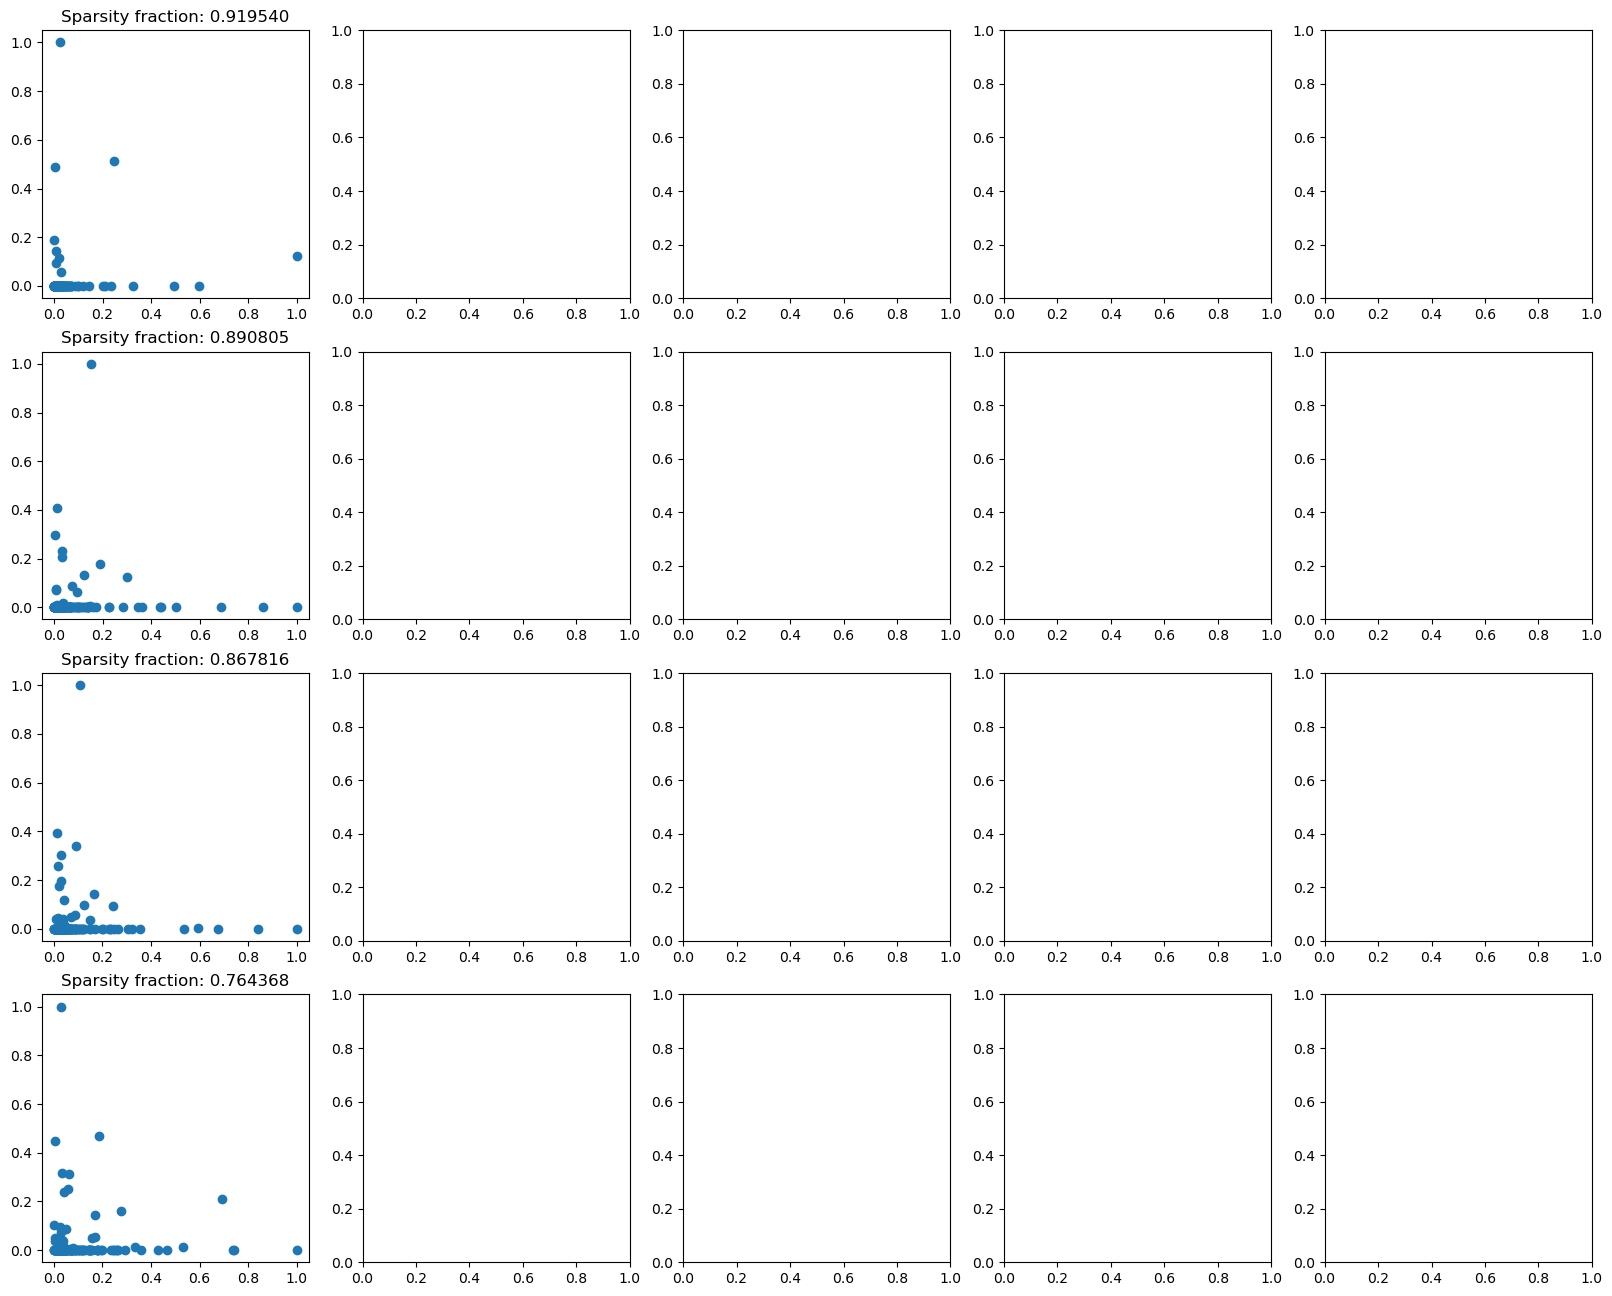

In [25]:
# Vary the rehsold we call zero, and compare leverage scores as a function of alpha
fig, ax = plt.subplots(4, 5, figsize=(20, 16))

alpha_idxs =  [0, 2, 4, 6, 8]

thresh = 1e-5

for i in range(4):
    for j in range(1):
        a = ax[i, j]
        c1 = coefs[i]
        c2 = scoefs[i, alpha_idxs[j]]

        l1 = calc_loadings(c1)
        l2 = calc_loadings(c2) 
        a.scatter(l1, l2)
        a.set_title('Sparsity fraction: %f' % (l2[l2 < thresh].size/l2.size))